## Data Collection

Main data collection is processed by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify.

This collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [95]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

In [96]:
# Place 
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian
channel_id_list = ['UCqnbDFdCpuN8CMEg0VuEBqA'] #NYTimes
channel_id_list = ['UCBi2mrWuNuyYy4gbM6fU18Q'] #ABCNews
channel_id_list = ['UCeY0bbntWzzVIaj2z3QigXg'] #NBCNews
channel_id_list = ['UCaXkIU1QidjPwiAYu6GcHjg'] #MSNBC

In [97]:
# Create Youtube Data API object & cleaned dataframe containing video data from selected channel using function from youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object
video_df = create_video_df(youtube_obj, channel_id_list, 500) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [98]:
selected_df = processed_video_df.query('viewCount > 5000 & commentCount > 500')

In [99]:
video_ids = list(selected_df['video_id'])

In [100]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [101]:
all_comments_df.head()

,video_id,comment_id,comment,date
0,MMc5lfQc8Q0,Ugwndct_fe7VlT9su-t4AaABAg,Be nice to him and he will come on the show.,2022-09-23T03:39:32Z
1,MMc5lfQc8Q0,UgyUAV9mO9c47RxCffN4AaABAg,"Couldn't happen to a nicer guy, LOL!! The whol...",2022-09-23T03:39:29Z
2,MMc5lfQc8Q0,UgxnEDDaE73hpV_vGoR4AaABAg,Trump is a complete and total baboon. 😅😅😂😅😂😂😅😂,2022-09-23T03:39:13Z
3,MMc5lfQc8Q0,UgwWfQhhEFlUlBZS-CZ4AaABAg,"Heh stupid trump, just shut up your big dirty ...",2022-09-23T03:39:08Z
4,MMc5lfQc8Q0,Ugy-61c7EwcRKev-b4B4AaABAg,45 U Lousy Losing Liar!!!,2022-09-23T03:38:28Z


In [102]:
all_comments_df['comment'][3]

'Heh stupid trump, just shut up your big dirty mouth for god sake.'

## Comment Data Cleaning

In [103]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [104]:
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

all_comments_df['comment'] = preprocess(all_comments_df['comment'])

In [105]:
all_comments_df

,video_id,comment_id,comment,date
0,MMc5lfQc8Q0,Ugwndct_fe7VlT9su-t4AaABAg,Be nice to him and he will come on the show.,2022-09-23T03:39:32Z
1,MMc5lfQc8Q0,UgyUAV9mO9c47RxCffN4AaABAg,"Couldn't happen to a nicer guy, LOL!! The whol...",2022-09-23T03:39:29Z
2,MMc5lfQc8Q0,UgxnEDDaE73hpV_vGoR4AaABAg,Trump is a complete and total baboon. 😅😅😂😅😂😂😅😂,2022-09-23T03:39:13Z
3,MMc5lfQc8Q0,UgwWfQhhEFlUlBZS-CZ4AaABAg,"Heh stupid trump, just shut up your big dirty ...",2022-09-23T03:39:08Z
4,MMc5lfQc8Q0,Ugy-61c7EwcRKev-b4B4AaABAg,45 U Lousy Losing Liar!!!,2022-09-23T03:38:28Z
...,...,...,...,...
28904,HXo70MJ5G9U,Ugz5N3hPVVNUGE2b0Nd4AaABAg,As an Independent voter their are no sane Repu...,2022-09-11T17:40:23Z
28905,HXo70MJ5G9U,UgzP2TSTb7FIqXkWj5h4AaABAg,The amount of greed that it takes to do what t...,2022-09-11T17:33:57Z
28906,HXo70MJ5G9U,UgzMg5rQf2lEFNBy9Bx4AaABAg,"Most republicans are *fully* aware, they just ...",2022-09-11T17:32:17Z
28907,HXo70MJ5G9U,UgyP2peGEO9_mTIV14N4AaABAg,Point blank republicans only give a crap about...,2022-09-11T17:06:30Z


In [106]:
all_comments_df['comment'][3]

'Heh stupid trump, just shut up your big dirty mouth for god sake.'

## VADER NLP

In [107]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [108]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()
    vid_likecount = processed_video_df.loc[processed_video_df['video_id'] == video, 'likeCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount,
            'vid_likecount': vid_likecount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [109]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,MMc5lfQc8Q0,Trump Admits To Willful Retention Of Documents...,-0.113013,73937,2440.0
1,NVXg70eLwDk,Joy Reid: Trump May Have Indicated He Intentio...,-0.041557,110528,3315.0
2,Mjq8-UGLVTY,DeSantis Investigated And Sued Over Migrant Fl...,-0.086627,34766,1788.0
3,uds82Ay37CE,Burn: See MAGA-Era Science Lies Roasted And De...,0.215299,98616,6427.0
4,mNHZ9KSU598,'Lunatic': Michael Cohen Demolishes Trump On D...,-0.001130,336040,12281.0
...,...,...,...,...,...
287,j-zKfQa-0u8,Hot Button Cultural Issues Become Winning Topi...,0.021833,39267,1168.0
288,CdJsDUyZSuw,Trump Faces Monday Deadline To Respond To DOJ ...,-0.081662,670782,11644.0
289,0EFKKOR4cZM,Full Speech: King Charles III Promises ‘Lifelo...,0.199905,276762,6477.0
290,--bPPcHXiD8,Watch Morning Joe Highlights: September 9 | MSNBC,-0.014135,104769,1854.0


## Data Visualization

In [110]:
fig = go.Figure()
fig.add_trace(go.Bar(x=selected_df['publishDayName'],
                y=selected_df['viewCount'],
                name='Rest of world',
                marker_color='rgb(55, 83, 109)'
                ))

fig.update_layout(
    title='View Count Based on Published Day of the Week',
    xaxis_tickfont_size=14,
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

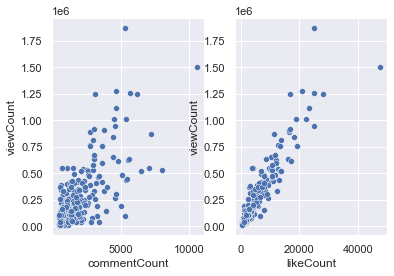

In [112]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = selected_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = selected_df, x = "likeCount", y = "viewCount", ax=ax[1])

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

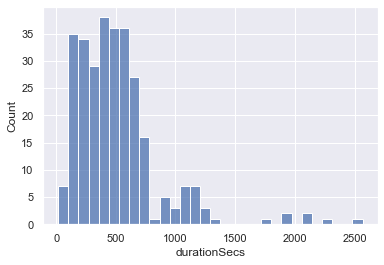

In [113]:
sns.histplot(data=selected_df[selected_df['durationSecs'] < 10000], x="durationSecs", bins=30)

Plotting the duration against comment count and like count. It can be seen that shorter videos tend to get more likes and comments than very long videos.

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

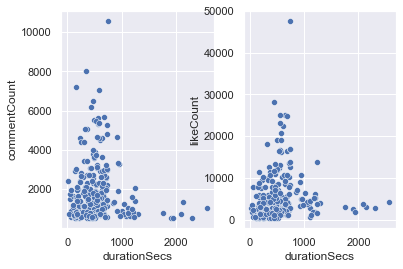

In [114]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = selected_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = selected_df, x = "durationSecs", y = "likeCount", ax=ax[1])

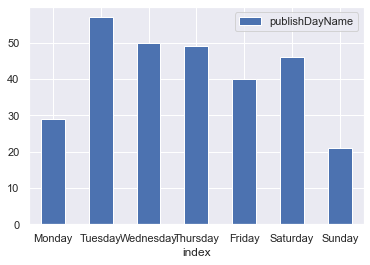

In [115]:
day_df = pd.DataFrame(selected_df['publishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)

In [116]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

Find the interactive graph [here](https://cjunwon.github.io/Youtube-Data-Analysis/).

In [117]:
from re import template


fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score",
    template='plotly_dark'
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='vscode')

pio.write_html(fig, file='index.html', auto_open=True)

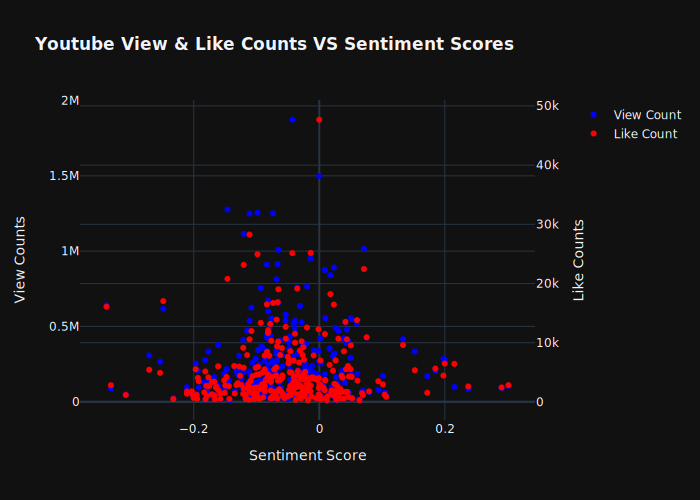

In [118]:
from re import template


fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        name='View Count',
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    name='Like Count',
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.update_layout(
    title="<b>Youtube View & Like Counts VS Sentiment Scores<b>",
    xaxis_title="Sentiment Score",
    template='plotly_dark'
)

fig.update_yaxes(title_text="View Counts", secondary_y=False)
fig.update_yaxes(title_text="Like Counts", secondary_y=True)

fig.show(renderer='svg')

# pio.write_html(fig, file='index.html', auto_open=True)

In [119]:
test_df = video_comp_sentiments

In [120]:
test_df

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,MMc5lfQc8Q0,Trump Admits To Willful Retention Of Documents...,-0.113013,73937,2440.0
1,NVXg70eLwDk,Joy Reid: Trump May Have Indicated He Intentio...,-0.041557,110528,3315.0
2,Mjq8-UGLVTY,DeSantis Investigated And Sued Over Migrant Fl...,-0.086627,34766,1788.0
3,uds82Ay37CE,Burn: See MAGA-Era Science Lies Roasted And De...,0.215299,98616,6427.0
4,mNHZ9KSU598,'Lunatic': Michael Cohen Demolishes Trump On D...,-0.001130,336040,12281.0
...,...,...,...,...,...
287,j-zKfQa-0u8,Hot Button Cultural Issues Become Winning Topi...,0.021833,39267,1168.0
288,CdJsDUyZSuw,Trump Faces Monday Deadline To Respond To DOJ ...,-0.081662,670782,11644.0
289,0EFKKOR4cZM,Full Speech: King Charles III Promises ‘Lifelo...,0.199905,276762,6477.0
290,--bPPcHXiD8,Watch Morning Joe Highlights: September 9 | MSNBC,-0.014135,104769,1854.0


In [121]:
test_df['avg_comp_sentiment'] = np.where(test_df['avg_comp_sentiment'] > 0, test_df['avg_comp_sentiment'] * 2, test_df['avg_comp_sentiment'])
test_df['avg_comp_sentiment'] = np.where(test_df['avg_comp_sentiment'] < 0, test_df['avg_comp_sentiment'] * -1, test_df['avg_comp_sentiment'])

In [122]:
test_df

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,MMc5lfQc8Q0,Trump Admits To Willful Retention Of Documents...,0.113013,73937,2440.0
1,NVXg70eLwDk,Joy Reid: Trump May Have Indicated He Intentio...,0.041557,110528,3315.0
2,Mjq8-UGLVTY,DeSantis Investigated And Sued Over Migrant Fl...,0.086627,34766,1788.0
3,uds82Ay37CE,Burn: See MAGA-Era Science Lies Roasted And De...,0.430598,98616,6427.0
4,mNHZ9KSU598,'Lunatic': Michael Cohen Demolishes Trump On D...,0.001130,336040,12281.0
...,...,...,...,...,...
287,j-zKfQa-0u8,Hot Button Cultural Issues Become Winning Topi...,0.043666,39267,1168.0
288,CdJsDUyZSuw,Trump Faces Monday Deadline To Respond To DOJ ...,0.081662,670782,11644.0
289,0EFKKOR4cZM,Full Speech: King Charles III Promises ‘Lifelo...,0.399810,276762,6477.0
290,--bPPcHXiD8,Watch Morning Joe Highlights: September 9 | MSNBC,0.014135,104769,1854.0


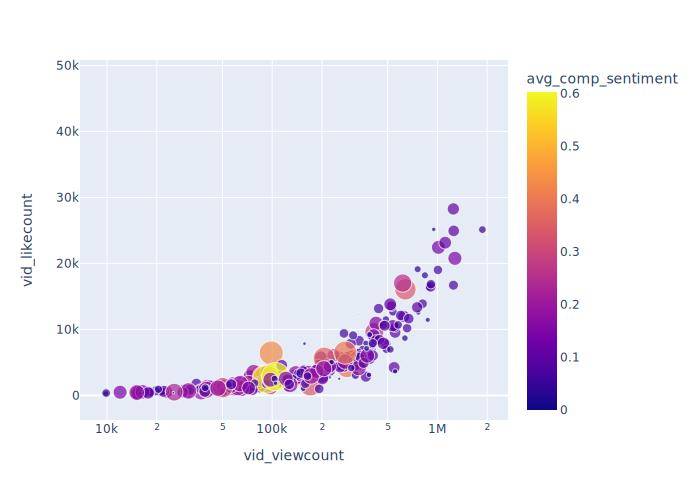

In [123]:
import plotly.express as px

fig = px.scatter(test_df, x="vid_viewcount", y="vid_likecount",
	         size="avg_comp_sentiment",
             color="avg_comp_sentiment", hover_name="vid_title", log_x=True)
fig.show(renderer='svg')